In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# from fastai.imports import *
# from fastai.torch_imports import *
# from fastai.io import *

In [3]:
from tqdm import tqdm
from tqdm.notebook import tnrange
from urllib.request import urlretrieve
import pickle
import gzip
import numpy as np
import matplotlib.pyplot as plt

from abc import abstractmethod
from collections.abc import Iterable
import collections

from concurrent.futures.thread import ThreadPoolExecutor

import torch
from torch._six import string_classes
from distutils.version import LooseVersion

In [4]:
ls -l

total 68
-rw-rw-r-- 1 ravimashru ravimashru 64034 Oct 12 17:06 'Lesson 4-Stripped [Code only].ipynb'
drwxrwxr-x 3 ravimashru ravimashru  4096 Oct 12 15:58  data/


In [5]:
path = 'data/mnist/'

In [6]:
import os
os.makedirs(path, exist_ok=True)

In [7]:
# URL='http://deeplearning.net/data/mnist/'
URL='https://figshare.com/ndownloader/files/25635053'
FILENAME='mnist.pkl.gz'

def load_mnist(filename):
    return pickle.load(gzip.open(filename, 'rb'), encoding='latin-1')

In [8]:
# from fastai/io.py
def get_data(url, filename):
    if not os.path.exists(filename):

        dirname = os.path.dirname(filename)
        if not os.path.exists(dirname):
            os.makedirs(dirname)

        with TqdmUpTo(unit='B', unit_scale=True, miniters=1, desc=url.split('/')[-1]) as t:
            urlretrieve(url, filename, reporthook=t.update_to)
            
            
# Docstring:     
# Decorate an iterable object, returning an iterator which acts exactly
# like the original iterable, but prints a dynamically updating
# progressbar every time a value is requested.
# Source:        
class TqdmUpTo(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None: self.total = tsize
        self.update(b * bsize - self.n)

In [9]:
# get_data(URL+FILENAME, path+FILENAME)
get_data(URL, path+FILENAME)
((x, y), (x_valid, y_valid), _) = load_mnist(path+FILENAME)

In [10]:
type(x), x.shape, type(y), y.shape

(numpy.ndarray, (50000, 784), numpy.ndarray, (50000,))

In [11]:
type(x_valid), x_valid.shape, type(y_valid), y_valid.shape

(numpy.ndarray, (10000, 784), numpy.ndarray, (10000,))

In [12]:
mean = x.mean()
std = x.std()

x=(x-mean)/std
mean, std, x.mean(), x.std()

(0.13044983, 0.3072898, -3.1638146e-07, 0.99999934)

In [13]:
x_valid = (x_valid-mean)/std
x_valid.mean(), x_valid.std()

(-0.005850922, 0.99243325)

In [14]:
def show(img, title=None):
    plt.imshow(img, cmap="gray")
    if title is not None: plt.title(title)

In [15]:
def plots(ims, figsize=(12,6), rows=2, titles=None):
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], cmap='gray')

In [16]:
x_valid.shape

(10000, 784)

In [17]:
x_imgs = np.reshape(x_valid, (-1,28,28)); x_imgs.shape

(10000, 28, 28)

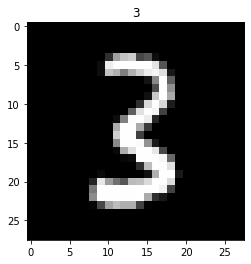

In [18]:
show(x_imgs[0], y_valid[0])

In [19]:
y_valid.shape

(10000,)

In [20]:
y_valid[0]

3

In [21]:
x_imgs[0,10:15,10:15]

array([[-0.42451727, -0.42451727, -0.42451727, -0.42451727,  0.17294396],
       [-0.42451727, -0.42451727, -0.42451727,  0.7831172 ,  2.4356694 ],
       [-0.42451727, -0.27197397,  1.2026112 ,  2.778892  ,  2.8043158 ],
       [-0.42451727,  1.7619367 ,  2.8043158 ,  2.8043158 ,  1.7365128 ],
       [-0.42451727,  2.2068546 ,  2.8043158 ,  2.8043158 ,  0.4017589 ]],
      dtype=float32)

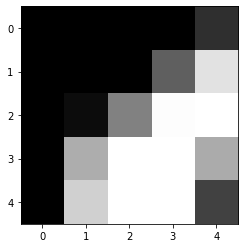

In [22]:
show(x_imgs[0,10:15,10:15])

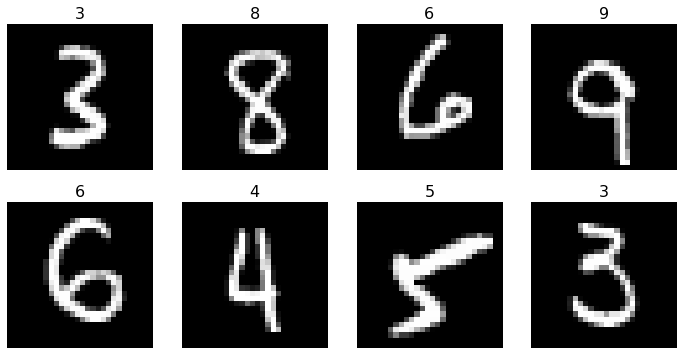

In [23]:
plots(x_imgs[:8], titles=y_valid[:8])

In [24]:
# from fastai.metrics import *
# from fastai.model import *
# from fastai.dataset import *

import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data.sampler import SequentialSampler, RandomSampler, BatchSampler
from torch import optim

In [25]:
net = nn.Sequential(
    nn.Linear(28*28, 100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Linear(100, 10),
    nn.LogSoftmax()
).cuda()

In [26]:
# from fastai/dataset.py

class BaseDataset(Dataset):
    """An abstract class representing a fastai dataset, it extends torch.utils.data.Dataset."""
    def __init__(self, transform=None):
        self.transform = transform
        self.n = self.get_n()
        self.c = self.get_c()
        self.sz = self.get_sz()

    def get1item(self, idx):
        x,y = self.get_x(idx),self.get_y(idx)
        return self.get(self.transform, x, y)

    def __getitem__(self, idx):
        if isinstance(idx,slice):
            xs,ys = zip(*[self.get1item(i) for i in range(*idx.indices(self.n))])
            return np.stack(xs),ys
        return self.get1item(idx)

    def __len__(self): return self.n

    def get(self, tfm, x, y):
        return (x,y) if tfm is None else tfm(x,y)

    @abstractmethod
    def get_n(self):
        """Return number of elements in the dataset == len(self)."""
        raise NotImplementedError

    @abstractmethod
    def get_c(self):
        """Return number of classes in a dataset."""
        raise NotImplementedError

    @abstractmethod
    def get_sz(self):
        """Return maximum size of an image in a dataset."""
        raise NotImplementedError

    @abstractmethod
    def get_x(self, i):
        """Return i-th example (image, wav, etc)."""
        raise NotImplementedError

    @abstractmethod
    def get_y(self, i):
        """Return i-th label."""
        raise NotImplementedError

    @property
    def is_multi(self):
        """Returns true if this data set contains multiple labels per sample."""
        return False

    @property
    def is_reg(self):
        """True if the data set is used to train regression models."""
        return False

class ArraysDataset(BaseDataset):
    def __init__(self, x, y, transform):
        self.x,self.y=x,y
        assert(len(x)==len(y))
        super().__init__(transform)
    def get_x(self, i): return self.x[i]
    def get_y(self, i): return self.y[i]
    def get_n(self): return len(self.y)
    def get_sz(self): return self.x.shape[1]

class ArraysIndexDataset(ArraysDataset):
    def get_c(self): return int(self.y.max())+1
    def get_y(self, i): return self.y[i]

class ModelData():
    def __init__(self, path, trn_dl, val_dl, test_dl=None):
        self.path,self.trn_dl,self.val_dl,self.test_dl = path,trn_dl,val_dl,test_dl

    @classmethod
    def from_dls(cls, path,trn_dl,val_dl,test_dl=None):
        #trn_dl,val_dl = DataLoader(trn_dl),DataLoader(val_dl)
        #if test_dl: test_dl = DataLoader(test_dl)
        return cls(path, trn_dl, val_dl, test_dl)

    @property
    def is_reg(self): return self.trn_ds.is_reg
    @property
    def is_multi(self): return self.trn_ds.is_multi
    @property
    def trn_ds(self): return self.trn_dl.dataset
    @property
    def val_ds(self): return self.val_dl.dataset
    @property
    def test_ds(self): return self.test_dl.dataset
    @property
    def trn_y(self): return self.trn_ds.y
    @property
    def val_y(self): return self.val_ds.y

class ImageData(ModelData):
    def __init__(self, path, datasets, bs, num_workers, classes):
        trn_ds,val_ds,fix_ds,aug_ds,test_ds,test_aug_ds = datasets
        self.path,self.bs,self.num_workers,self.classes = path,bs,num_workers,classes
        self.trn_dl,self.val_dl,self.fix_dl,self.aug_dl,self.test_dl,self.test_aug_dl = [
            self.get_dl(ds,shuf) for ds,shuf in [
                (trn_ds,True),(val_ds,False),(fix_ds,False),(aug_ds,False),
                (test_ds,False),(test_aug_ds,False)
            ]
        ]

    def get_dl(self, ds, shuffle):
        if ds is None: return None
        return DataLoader(ds, batch_size=self.bs, shuffle=shuffle,
            num_workers=self.num_workers, pin_memory=False)

    @property
    def sz(self): return self.trn_ds.sz
    @property
    def c(self): return self.trn_ds.c

    def resized(self, dl, targ, new_path):
        return dl.dataset.resize_imgs(targ,new_path) if dl else None

    def resize(self, targ_sz, new_path='tmp'):
        new_ds = []
        dls = [self.trn_dl,self.val_dl,self.fix_dl,self.aug_dl]
        if self.test_dl: dls += [self.test_dl, self.test_aug_dl]
        else: dls += [None,None]
        t = tqdm_notebook(dls)
        for dl in t: new_ds.append(self.resized(dl, targ_sz, new_path))
        t.close()
        return self.__class__(new_ds[0].path, new_ds, self.bs, self.num_workers, self.classes)

    @staticmethod
    def get_ds(fn, trn, val, tfms, test=None, **kwargs):
        res = [
            fn(trn[0], trn[1], tfms[0], **kwargs), # train
            fn(val[0], val[1], tfms[1], **kwargs), # val
            fn(trn[0], trn[1], tfms[1], **kwargs), # fix
            fn(val[0], val[1], tfms[0], **kwargs)  # aug
        ]
        if test is not None:
            if isinstance(test, tuple):
                test_lbls = test[1]
                test = test[0]
            else:
                test_lbls = np.zeros((len(test),1))
            res += [
                fn(test, test_lbls, tfms[1], **kwargs), # test
                fn(test, test_lbls, tfms[0], **kwargs)  # test_aug
            ]
        else: res += [None,None]
        return res

class ImageClassifierData(ImageData):
    @classmethod
    def from_arrays(cls, path, trn, val, bs=64, tfms=(None,None), classes=None, num_workers=4, test=None):
        """ Read in images and their labels given as numpy arrays

        Arguments:
            path: a root path of the data (used for storing trained models, precomputed values, etc)
            trn: a tuple of training data matrix and target label/classification array (e.g. `trn=(x,y)` where `x` has the
                shape of `(5000, 784)` and `y` has the shape of `(5000,)`)
            val: a tuple of validation data matrix and target label/classification array.
            bs: batch size
            tfms: transformations (for data augmentations). e.g. output of `tfms_from_model`
            classes: a list of all labels/classifications
            num_workers: a number of workers
            test: a matrix of test data (the shape should match `trn[0]`)

        Returns:
            ImageClassifierData
        """
        datasets = cls.get_ds(ArraysIndexDataset, trn, val, tfms, test=test)
        return cls(path, datasets, bs, num_workers, classes=classes)

    @classmethod
    def from_paths(cls, path, bs=64, tfms=(None,None), trn_name='train', val_name='valid', test_name=None, test_with_labels=False, num_workers=8):
        """ Read in images and their labels given as sub-folder names

        Arguments:
            path: a root path of the data (used for storing trained models, precomputed values, etc)
            bs: batch size
            tfms: transformations (for data augmentations). e.g. output of `tfms_from_model`
            trn_name: a name of the folder that contains training images.
            val_name:  a name of the folder that contains validation images.
            test_name:  a name of the folder that contains test images.
            num_workers: number of workers

        Returns:
            ImageClassifierData
        """
        assert not(tfms[0] is None or tfms[1] is None), "please provide transformations for your train and validation sets"
        trn,val = [folder_source(path, o) for o in (trn_name, val_name)]
        if test_name:
            test = folder_source(path, test_name) if test_with_labels else read_dir(path, test_name)
        else: test = None
        datasets = cls.get_ds(FilesIndexArrayDataset, trn, val, tfms, path=path, test=test)
        return cls(path, datasets, bs, num_workers, classes=trn[2])

    @classmethod
    def from_csv(cls, path, folder, csv_fname, bs=64, tfms=(None,None),
               val_idxs=None, suffix='', test_name=None, continuous=False, skip_header=True, num_workers=8):
        """ Read in images and their labels given as a CSV file.

        This method should be used when training image labels are given in an CSV file as opposed to
        sub-directories with label names.

        Arguments:
            path: a root path of the data (used for storing trained models, precomputed values, etc)
            folder: a name of the folder in which training images are contained.
            csv_fname: a name of the CSV file which contains target labels.
            bs: batch size
            tfms: transformations (for data augmentations). e.g. output of `tfms_from_model`
            val_idxs: index of images to be used for validation. e.g. output of `get_cv_idxs`.
                If None, default arguments to get_cv_idxs are used.
            suffix: suffix to add to image names in CSV file (sometimes CSV only contains the file name without file
                    extension e.g. '.jpg' - in which case, you can set suffix as '.jpg')
            test_name: a name of the folder which contains test images.
            continuous: TODO
            skip_header: skip the first row of the CSV file.
            num_workers: number of workers

        Returns:
            ImageClassifierData
        """
        assert not (tfms[0] is None or tfms[1] is None), "please provide transformations for your train and validation sets"
        assert not (os.path.isabs(folder)), "folder needs to be a relative path"
        fnames,y,classes = csv_source(folder, csv_fname, skip_header, suffix, continuous=continuous)
        return cls.from_names_and_array(path, fnames, y, classes, val_idxs, test_name,
                num_workers=num_workers, suffix=suffix, tfms=tfms, bs=bs, continuous=continuous)

    @classmethod
    def from_names_and_array(cls, path, fnames,y,classes, val_idxs=None, test_name=None,
            num_workers=8, suffix='', tfms=(None,None), bs=64, continuous=False):
        val_idxs = get_cv_idxs(len(fnames)) if val_idxs is None else val_idxs
        ((val_fnames,trn_fnames),(val_y,trn_y)) = split_by_idx(val_idxs, np.array(fnames), y)

        test_fnames = read_dir(path, test_name) if test_name else None
        if continuous: f = FilesIndexArrayRegressionDataset
        else:
            f = FilesIndexArrayDataset if len(trn_y.shape)==1 else FilesNhotArrayDataset
        datasets = cls.get_ds(f, (trn_fnames,trn_y), (val_fnames,val_y), tfms,
                               path=path, test=test_fnames)
        return cls(path, datasets, bs, num_workers, classes=classes)

In [27]:
# from fastai/dataloader.py

class DataLoader(object):
    def __init__(self, dataset, batch_size=1, shuffle=False, sampler=None, batch_sampler=None, pad_idx=0,
                 num_workers=None, pin_memory=False, drop_last=False, pre_pad=True, half=False,
                 transpose=False, transpose_y=False):
        self.dataset,self.batch_size,self.num_workers = dataset,batch_size,num_workers
        self.pin_memory,self.drop_last,self.pre_pad = pin_memory,drop_last,pre_pad
        self.transpose,self.transpose_y,self.pad_idx,self.half = transpose,transpose_y,pad_idx,half

        if batch_sampler is not None:
            if batch_size > 1 or shuffle or sampler is not None or drop_last:
                raise ValueError('batch_sampler is mutually exclusive with '
                                 'batch_size, shuffle, sampler, and drop_last')

        if sampler is not None and shuffle:
            raise ValueError('sampler is mutually exclusive with shuffle')

        if batch_sampler is None:
            if sampler is None:
                sampler = RandomSampler(dataset) if shuffle else SequentialSampler(dataset)
            batch_sampler = BatchSampler(sampler, batch_size, drop_last)

        if num_workers is None:
            self.num_workers = num_cpus()

        self.sampler = sampler
        self.batch_sampler = batch_sampler

    def __len__(self): return len(self.batch_sampler)

    def jag_stack(self, b):
        if len(b[0].shape) not in (1,2): return np.stack(b)
        ml = max(len(o) for o in b)
        if min(len(o) for o in b)==ml: return np.stack(b)
        res = np.zeros((len(b), ml), dtype=b[0].dtype) + self.pad_idx
        for i,o in enumerate(b):
            if self.pre_pad: res[i, -len(o):] = o
            else:            res[i,  :len(o)] = o
        return res

    def np_collate(self, batch):
        b = batch[0]
        if isinstance(b, (np.ndarray, np.generic)): return self.jag_stack(batch)
        elif isinstance(b, (int, float)): return np.array(batch)
        elif isinstance(b, string_classes): return batch
        elif isinstance(b, collections.Mapping):
            return {key: self.np_collate([d[key] for d in batch]) for key in b}
        elif isinstance(b, collections.Sequence):
            return [self.np_collate(samples) for samples in zip(*batch)]
        raise TypeError(("batch must contain numbers, dicts or lists; found {}".format(type(b))))

    def get_batch(self, indices):
        res = self.np_collate([self.dataset[i] for i in indices])
        if self.transpose:   res[0] = res[0].T
        if self.transpose_y: res[1] = res[1].T
        return res

    def __iter__(self):
        if self.num_workers==0:
            for batch in map(self.get_batch, iter(self.batch_sampler)):
                yield get_tensor(batch, self.pin_memory, self.half)
        else:
            with ThreadPoolExecutor(max_workers=self.num_workers) as e:
                # avoid py3.6 issue where queue is infinite and can result in memory exhaustion
                for c in chunk_iter(iter(self.batch_sampler), self.num_workers*10):
                    for batch in e.map(self.get_batch, c):
                        yield get_tensor(batch, self.pin_memory, self.half)

In [28]:
md = ImageClassifierData.from_arrays(path, (x,y), (x_valid, y_valid))

In [29]:
# from fastai/metrics.py

def accuracy(preds, targs):
    preds = torch.max(preds, dim=1)[1]
    return (preds==targs).float().mean()

In [30]:
loss=nn.NLLLoss()
metrics=[accuracy]
# opt=optim.SGD(net.parameters(), 1e-1, momentum=0.9)
opt=optim.SGD(net.parameters(), 1e-1, momentum=0.9, weight_decay=1e-3)

In [31]:
def binary_loss(y, p):
    return np.mean(-(y * np.log(p) + (1-y)*np.log(1-p)))

In [32]:
acts = np.array([1, 0, 0, 1])
preds = np.array([0.9, 0.1, 0.2, 0.8])
binary_loss(acts, preds)

0.164252033486018

In [33]:
# from fastai/core.py

def apply_leaf(m, f):
    c = children(m)
    if isinstance(m, nn.Module): f(m)
    if len(c)>0:
        for l in c: apply_leaf(l,f)

In [34]:
# from fastai/model.py

def set_train_mode(m):
    if (hasattr(m, 'running_mean') and (getattr(m,'bn_freeze',False)
              or not getattr(m,'trainable',False))): m.eval()
    elif (getattr(m,'drop_freeze',False) and hasattr(m, 'p')
          and ('drop' in type(m).__name__.lower())): m.eval()
    else: m.train()

class Stepper():
    def __init__(self, m, opt, crit, clip=0, reg_fn=None, fp16=False, loss_scale=1):
        self.m,self.opt,self.crit,self.clip,self.reg_fn = m,opt,crit,clip,reg_fn
        self.fp16 = fp16
        self.reset(True)
        if self.fp16: self.fp32_params = copy_model_to_fp32(m, opt)
        self.loss_scale = loss_scale

    def reset(self, train=True):
        if train: apply_leaf(self.m, set_train_mode)
        else: self.m.eval()
        if hasattr(self.m, 'reset'):
            self.m.reset()
            if self.fp16: self.fp32_params = copy_model_to_fp32(self.m, self.opt)

    def step(self, xs, y, epoch):
        xtra = []
        output = self.m(*xs)
        if isinstance(output,tuple): output,*xtra = output
        if self.fp16: self.m.zero_grad()
        else: self.opt.zero_grad() 
        loss = raw_loss = self.crit(output, y)
        if self.loss_scale != 1: assert(self.fp16); loss = loss*self.loss_scale
        if self.reg_fn: loss = self.reg_fn(output, xtra, raw_loss)
        loss.backward()
        if self.fp16: update_fp32_grads(self.fp32_params, self.m)
        if self.loss_scale != 1:
            for param in self.fp32_params: param.grad.data.div_(self.loss_scale)
        if self.clip:   # Gradient clipping
            nn.utils.clip_grad_norm(trainable_params_(self.m), self.clip)
        self.opt.step()
        if self.fp16: 
            copy_fp32_to_model(self.m, self.fp32_params)
            torch.cuda.synchronize()
        return torch_item(raw_loss.data)

    def evaluate(self, xs, y):
        preds = self.m(*xs)
        if isinstance(preds,tuple): preds=preds[0]
        return preds, self.crit(preds, y)

def fit(model, data, n_epochs, opt, crit, metrics=None, callbacks=None, stepper=Stepper,
        swa_model=None, swa_start=None, swa_eval_freq=None, **kwargs):
    """ Fits a model

    Arguments:
       model (model): any pytorch module
           net = to_gpu(net)
       data (ModelData): see ModelData class and subclasses (can be a list)
       opts: an optimizer. Example: optim.Adam. 
       If n_epochs is a list, it needs to be the layer_optimizer to get the optimizer as it changes.
       n_epochs(int or list): number of epochs (or list of number of epochs)
       crit: loss function to optimize. Example: F.cross_entropy
    """

    all_val = kwargs.pop('all_val') if 'all_val' in kwargs else False
    get_ep_vals = kwargs.pop('get_ep_vals') if 'get_ep_vals' in kwargs else False
    metrics = metrics or []
    callbacks = callbacks or []
    avg_mom=0.98
    batch_num,avg_loss=0,0.
    for cb in callbacks: cb.on_train_begin()
    names = ["epoch", "trn_loss", "val_loss"] + [f.__name__ for f in metrics]
    if swa_model is not None:
        swa_names = ['swa_loss'] + [f'swa_{f.__name__}' for f in metrics]
        names += swa_names
        # will use this to call evaluate later
        swa_stepper = stepper(swa_model, None, crit, **kwargs)

    layout = "{!s:10} " * len(names)
    if not isinstance(n_epochs, Iterable): n_epochs=[n_epochs]
    if not isinstance(data, Iterable): data = [data]
    if len(data) == 1: data = data * len(n_epochs)
    for cb in callbacks: cb.on_phase_begin()
    model_stepper = stepper(model, opt.opt if hasattr(opt,'opt') else opt, crit, **kwargs)
    ep_vals = collections.OrderedDict()
    tot_epochs = int(np.ceil(np.array(n_epochs).sum()))
    cnt_phases = np.array([ep * len(dat.trn_dl) for (ep,dat) in zip(n_epochs,data)]).cumsum()
    phase = 0
    for epoch in tnrange(tot_epochs, desc='Epoch'):
        model_stepper.reset(True)
        cur_data = data[phase]
        if hasattr(cur_data, 'trn_sampler'): cur_data.trn_sampler.set_epoch(epoch)
        if hasattr(cur_data, 'val_sampler'): cur_data.val_sampler.set_epoch(epoch)
        num_batch = len(cur_data.trn_dl)
        t = tqdm(iter(cur_data.trn_dl), leave=False, total=num_batch)
        if all_val: val_iter = IterBatch(cur_data.val_dl)

        for (*x,y) in t:
            batch_num += 1
            for cb in callbacks: cb.on_batch_begin()
            loss = model_stepper.step(V(x),V(y), epoch)
            avg_loss = avg_loss * avg_mom + loss * (1-avg_mom)
            debias_loss = avg_loss / (1 - avg_mom**batch_num)
            t.set_postfix(loss=debias_loss)
            stop=False
            los = debias_loss if not all_val else [debias_loss] + validate_next(model_stepper,metrics, val_iter)
            for cb in callbacks: stop = stop or cb.on_batch_end(los)
            if stop: return
            if batch_num >= cnt_phases[phase]:
                for cb in callbacks: cb.on_phase_end()
                phase += 1
                if phase >= len(n_epochs):
                    t.close()
                    break
                for cb in callbacks: cb.on_phase_begin()
                if isinstance(opt, LayerOptimizer): model_stepper.opt = opt.opt
                if cur_data != data[phase]:
                    t.close()
                    break

        if not all_val:
            vals = validate(model_stepper, cur_data.val_dl, metrics)
            stop=False
            for cb in callbacks: stop = stop or cb.on_epoch_end(vals)
            if swa_model is not None:
                if (epoch + 1) >= swa_start and ((epoch + 1 - swa_start) % swa_eval_freq == 0 or epoch == tot_epochs - 1):
                    fix_batchnorm(swa_model, cur_data.trn_dl)
                    swa_vals = validate(swa_stepper, cur_data.val_dl, metrics)
                    vals += swa_vals

            if epoch == 0: print(layout.format(*names))
            print_stats(epoch, [debias_loss] + vals)
            ep_vals = append_stats(ep_vals, epoch, [debias_loss] + vals)
        if stop: break
    for cb in callbacks: cb.on_train_end()
    if get_ep_vals: return vals, ep_vals
    else: return vals

In [35]:
# from fastai/torch_imports.py

def children(m): return m if isinstance(m, (list, tuple)) else list(m.children())

In [36]:
# from fastai/core.py

def chunk_iter(iterable, chunk_size):
    '''A generator that yields chunks of iterable, chunk_size at a time. '''
    while True:
        chunk = []
        try:
            for _ in range(chunk_size): chunk.append(next(iterable))
            yield chunk
        except StopIteration:
            if chunk: yield chunk
            break

In [37]:
# from fastai/dataloader.py

def get_tensor(batch, pin, half=False):
    if isinstance(batch, (np.ndarray, np.generic)):
        batch = T(batch, half=half, cuda=False).contiguous()
        if pin: batch = batch.pin_memory()
        return to_gpu(batch)
    elif isinstance(batch, string_classes):
        return batch
    elif isinstance(batch, collections.Mapping):
        return {k: get_tensor(sample, pin, half) for k, sample in batch.items()}
    elif isinstance(batch, collections.Sequence):
        return [get_tensor(sample, pin, half) for sample in batch]
    raise TypeError(f"batch must contain numbers, dicts or lists; found {type(batch)}")

In [54]:
# from fastai/core.py

def is_listy(x): return isinstance(x, (list,tuple))
def map_over(x, f): return [f(o) for o in x] if is_listy(x) else f(x)

def create_variable(x, volatile, requires_grad=False):
    if type (x) != Variable:
        if IS_TORCH_04: x = Variable(T(x), requires_grad=requires_grad)
        else:           x = Variable(T(x), requires_grad=requires_grad, volatile=volatile)
    return x

def V_(x, requires_grad=False, volatile=False):
    '''equivalent to create_variable, which creates a pytorch tensor'''
    return create_variable(x, volatile=volatile, requires_grad=requires_grad)

def V(x, requires_grad=False, volatile=False):
    '''creates a single or a list of pytorch tensors, depending on input x. '''
    return map_over(x, lambda o: V_(o, requires_grad, volatile))

def VV_(x): 
    '''creates a volatile tensor, which does not require gradients. '''
    return create_variable(x, True)

def VV(x):
    '''creates a single or a list of pytorch tensors, depending on input x. '''
    return map_over(x, VV_)

def to_np(v):
    '''returns an np.array object given an input of np.array, list, tuple, torch variable or tensor.'''
    if isinstance(v, float): return np.array(v)
    if isinstance(v, (np.ndarray, np.generic)): return v
    if isinstance(v, (list,tuple)): return [to_np(o) for o in v]
    if isinstance(v, Variable): v=v.data
    if torch.cuda.is_available():
        if is_half_tensor(v): v=v.float()
    if isinstance(v, torch.FloatTensor): v=v.float()
    return v.cpu().numpy()

def is_half_tensor(v):
    return isinstance(v, torch.cuda.HalfTensor)

IS_TORCH_04 = LooseVersion(torch.__version__) >= LooseVersion('0.4')
USE_GPU = torch.cuda.is_available()
def to_gpu(x, *args, **kwargs):
    '''puts pytorch variable to gpu, if cuda is available and USE_GPU is set to true. '''
    return x.cuda(*args, **kwargs) if USE_GPU else x

def T(a, half=False, cuda=True):
    """
    Convert numpy array into a pytorch tensor. 
    if Cuda is available and USE_GPU=ture, store resulting tensor in GPU.
    """
    if not torch.is_tensor(a):
        a = np.array(np.ascontiguousarray(a))
        if a.dtype in (np.int8, np.int16, np.int32, np.int64):
            a = torch.LongTensor(a.astype(np.int64))
        elif a.dtype in (np.float32, np.float64):
            a = torch.cuda.HalfTensor(a) if half else torch.FloatTensor(a)
        else: raise NotImplementedError(a.dtype)
           
    # was `async=True` in fastai, changed to `non_blocking=True`
    # See: https://stackoverflow.com/a/53212781/5774633
    if cuda: a = to_gpu(a, non_blocking=True)
    return a

In [55]:
from torch.autograd.variable import Variable

In [88]:
# from fastai/model.py

def append_stats(ep_vals, epoch, values, decimals=6):
    ep_vals[epoch]=list(np.round(values, decimals))
    return ep_vals

def print_stats(epoch, values, decimals=6):
    layout = "{!s:^10}" + " {!s:10}" * len(values)
    values = [epoch] + list(np.round(values, decimals))
    print(layout.format(*values))

def torch_item(x): return x.item() if hasattr(x,'item') else x[0]

def validate(stepper, dl, metrics):
    batch_cnts,loss,res = [],[],[]
    stepper.reset(False)
    with no_grad_context():
        for (*x,y) in iter(dl):
            preds, l = stepper.evaluate(VV(x), VV(y))
            if isinstance(x,list): batch_cnts.append(len(x[0]))
            else: batch_cnts.append(len(x))
            loss.append(to_np(l))
            res.append([f(preds.data, y).cpu() for f in metrics])

    return [np.average(loss, 0, weights=batch_cnts)] + list(np.average(np.stack(res), 0, weights=batch_cnts))

def no_grad_context(): return torch.no_grad() if IS_TORCH_04 else contextlib.suppress()

In [89]:
fit(net, md, n_epochs=5, crit=loss, opt=opt, metrics=metrics)

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]


 98%|██████████████████████████████▎| 764/782 [00:03<00:00, 202.60it/s, loss=0.198]
                                                                                   

<class 'numpy.ndarray'>
<class 'int'>
<class 'torch.Tensor'>
epoch      trn_loss   val_loss   accuracy   
    0      0.198053   0.214186   0.9424    



 98%|██████████████████████████████▏| 763/782 [00:03<00:00, 191.72it/s, loss=0.224]
                                                                                   

<class 'numpy.ndarray'>
<class 'int'>
<class 'torch.Tensor'>
    1      0.224005   0.178397   0.9526    



 99%|███████████████████████████████▋| 775/782 [00:03<00:00, 213.84it/s, loss=0.21]
                                                                                   

<class 'numpy.ndarray'>
<class 'int'>
<class 'torch.Tensor'>
    2      0.210379   0.218615   0.9381    



 97%|██████████████████████████████▏| 762/782 [00:03<00:00, 205.39it/s, loss=0.191]
                                                                                   

<class 'numpy.ndarray'>
<class 'int'>
<class 'torch.Tensor'>
    3      0.191119   0.152285   0.9568    



 97%|██████████████████████████████▏| 761/782 [00:03<00:00, 208.11it/s, loss=0.192]
                                                                                   

<class 'numpy.ndarray'>
<class 'int'>
<class 'torch.Tensor'>
    4      0.19197    0.205218   0.945     


[0.20521753058135508, 0.945]

In [93]:
# from fastai/layer_optimizer.py

def zip_strict_(l, r):
    assert(len(l) == len(r))
    return zip(l, r)

def set_lrs(opt, lrs):
    if not isinstance(lrs, Iterable): lrs=[lrs]
    if len(lrs)==1: lrs=lrs*len(opt.param_groups)
    for pg,lr in zip_strict_(opt.param_groups,lrs): pg['lr'] = lr

In [94]:
set_lrs(opt, 1e-2)

In [95]:
fit(net, md, n_epochs=3, crit=loss, opt=opt, metrics=metrics)

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]


 99%|█████████████████████████████▋| 774/782 [00:03<00:00, 213.53it/s, loss=0.0584]
                                                                                   

<class 'numpy.ndarray'>
<class 'int'>
<class 'torch.Tensor'>
epoch      trn_loss   val_loss   accuracy   
    0      0.058416   0.087429   0.9744    



 99%|█████████████████████████████▊| 776/782 [00:03<00:00, 215.92it/s, loss=0.0521]
                                                                                   

<class 'numpy.ndarray'>
<class 'int'>
<class 'torch.Tensor'>
    1      0.052135   0.080683   0.9764    



 99%|█████████████████████████████▊| 778/782 [00:03<00:00, 209.05it/s, loss=0.0499]
                                                                                   

<class 'numpy.ndarray'>
<class 'int'>
<class 'torch.Tensor'>
    2      0.049894   0.074164   0.9767    


[0.074163898287341, 0.9767]

In [96]:
fit(net, md, n_epochs=5, crit=loss, opt=opt, metrics=metrics)

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]


 99%|█████████████████████████████▋| 775/782 [00:03<00:00, 205.52it/s, loss=0.0412]
                                                                                   

<class 'numpy.ndarray'>
<class 'int'>
<class 'torch.Tensor'>
epoch      trn_loss   val_loss   accuracy   
    0      0.041241   0.073225   0.9777    



 97%|██████████████████████████████▏| 761/782 [00:03<00:00, 216.49it/s, loss=0.036]
                                                                                   

<class 'numpy.ndarray'>
<class 'int'>
<class 'torch.Tensor'>
    1      0.035955   0.070339   0.9789    



 99%|█████████████████████████████▊| 777/782 [00:03<00:00, 219.47it/s, loss=0.0341]
                                                                                   

<class 'numpy.ndarray'>
<class 'int'>
<class 'torch.Tensor'>
    2      0.034086   0.066195   0.9791    



 99%|█████████████████████████████▋| 774/782 [00:03<00:00, 209.95it/s, loss=0.0308]
                                                                                   

<class 'numpy.ndarray'>
<class 'int'>
<class 'torch.Tensor'>
    3      0.030779   0.069053   0.9787    



 98%|█████████████████████████████▎| 763/782 [00:03<00:00, 200.67it/s, loss=0.0263]
                                                                                   

<class 'numpy.ndarray'>
<class 'int'>
<class 'torch.Tensor'>
    4      0.026293   0.064829   0.9803    


[0.0648292243849486, 0.9803]

In [97]:
set_lrs(opt, 1e-2)

In [98]:
fit(net, md, n_epochs=3, crit=loss, opt=opt, metrics=metrics)

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]


 99%|██████████████████████████████▋| 775/782 [00:03<00:00, 210.87it/s, loss=0.025]
                                                                                   

<class 'numpy.ndarray'>
<class 'int'>
<class 'torch.Tensor'>
epoch      trn_loss   val_loss   accuracy   
    0      0.024987   0.066346   0.9791    



 98%|█████████████████████████████▍| 766/782 [00:03<00:00, 207.15it/s, loss=0.0287]
                                                                                   

<class 'numpy.ndarray'>
<class 'int'>
<class 'torch.Tensor'>
    1      0.028714   0.069304   0.9793    



 99%|█████████████████████████████▋| 775/782 [00:03<00:00, 202.00it/s, loss=0.0252]
                                                                                   

<class 'numpy.ndarray'>
<class 'int'>
<class 'torch.Tensor'>
    2      0.025223   0.070731   0.9784    


[0.0707313017450273, 0.9784]

In [99]:
t = [o.numel() for o in net.parameters()]
t, sum(t)

([78400, 100, 10000, 100, 1000, 10], 89610)

In [103]:
# from fastai/model.py

def get_prediction(x):
    if is_listy(x): x=x[0]
    return x.data

def predict_with_targs_(m, dl):
    m.eval()
    if hasattr(m, 'reset'): m.reset()
    res = []
    for *x,y in iter(dl): res.append([get_prediction(m(*VV(x))),y])
    return zip(*res)

def predict(m, dl):
    preda,_ = predict_with_targs_(m, dl)
    return to_np(torch.cat(preda))

In [104]:
preds = predict(net, md.val_dl)

In [105]:
preds.shape

(10000, 10)

In [106]:
preds.argmax(axis=1)[:5]

array([3, 8, 6, 9, 6])

In [107]:
preds = preds.argmax(1)

In [108]:
np.mean(preds == y_valid)

0.9784

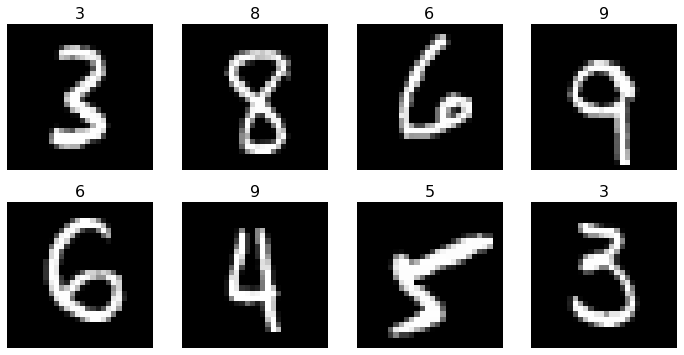

In [109]:
plots(x_imgs[:8], titles=preds[:8])

In [110]:
def get_weights(*dims): return nn.Parameter(torch.randn(dims)/dims[0])
def softmax(x): return torch.exp(x)/(torch.exp(x).sum(dim=1)[:,None])

class LogReg(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1_w = get_weights(28*28, 10)  # Layer 1 weights
        self.l1_b = get_weights(10)         # Layer 1 bias

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = (x @ self.l1_w) + self.l1_b  # Linear Layer
        x = torch.log(softmax(x)) # Non-linear (LogSoftmax) Layer
        return x

In [111]:
net2 = LogReg().cuda()
opt=optim.Adam(net2.parameters())

In [112]:
fit(net2, md, n_epochs=1, crit=loss, opt=opt, metrics=metrics)

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]


 97%|██████████████████████████████▏| 760/782 [00:03<00:00, 217.81it/s, loss=0.316]
                                                                                   

<class 'numpy.ndarray'>
<class 'int'>
<class 'torch.Tensor'>
epoch      trn_loss   val_loss   accuracy   
    0      0.316454   0.288423   0.9187    


[0.2884228831291199, 0.9187]

In [113]:
dl = iter(md.trn_dl)

In [114]:
xmb,ymb = next(dl)

In [115]:
vxmb = Variable(xmb.cuda())
vxmb

tensor([[-0.4245, -0.4245, -0.4245,  ..., -0.4245, -0.4245, -0.4245],
        [-0.4245, -0.4245, -0.4245,  ..., -0.4245, -0.4245, -0.4245],
        [-0.4245, -0.4245, -0.4245,  ..., -0.4245, -0.4245, -0.4245],
        ...,
        [-0.4245, -0.4245, -0.4245,  ..., -0.4245, -0.4245, -0.4245],
        [-0.4245, -0.4245, -0.4245,  ..., -0.4245, -0.4245, -0.4245],
        [-0.4245, -0.4245, -0.4245,  ..., -0.4245, -0.4245, -0.4245]],
       device='cuda:0')

In [116]:
preds = net2(vxmb).exp(); preds[:3]

tensor([[2.7160e-04, 3.3044e-04, 1.2862e-06, 9.2521e-05, 5.9066e-01, 3.0198e-02,
         1.6137e-05, 3.0214e-01, 5.1089e-02, 2.5199e-02],
        [1.0327e-02, 3.7231e-05, 1.6553e-01, 1.3048e-03, 6.4282e-01, 7.5270e-03,
         6.1382e-02, 2.5804e-04, 2.8468e-02, 8.2343e-02],
        [3.5685e-06, 5.1537e-03, 2.1273e-02, 1.6131e-03, 6.1676e-03, 6.8350e-04,
         9.1496e-01, 1.0954e-05, 4.8300e-02, 1.8332e-03]], device='cuda:0',
       grad_fn=<SliceBackward>)

In [117]:
preds = net2(vxmb).exp(); preds[:3]

tensor([[2.7160e-04, 3.3044e-04, 1.2862e-06, 9.2521e-05, 5.9066e-01, 3.0198e-02,
         1.6137e-05, 3.0214e-01, 5.1089e-02, 2.5199e-02],
        [1.0327e-02, 3.7231e-05, 1.6553e-01, 1.3048e-03, 6.4282e-01, 7.5270e-03,
         6.1382e-02, 2.5804e-04, 2.8468e-02, 8.2343e-02],
        [3.5685e-06, 5.1537e-03, 2.1273e-02, 1.6131e-03, 6.1676e-03, 6.8350e-04,
         9.1496e-01, 1.0954e-05, 4.8300e-02, 1.8332e-03]], device='cuda:0',
       grad_fn=<SliceBackward>)

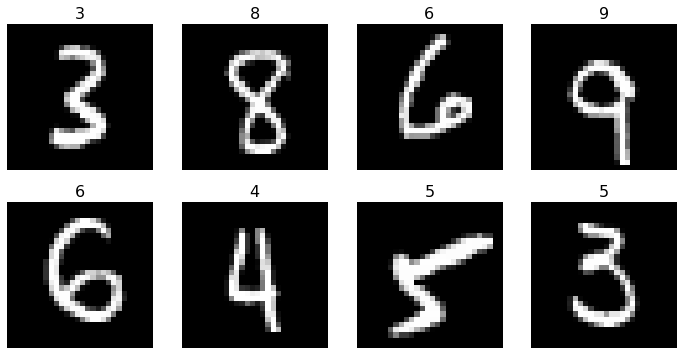

In [118]:
preds = predict(net2, md.val_dl).argmax(1)
plots(x_imgs[:8], titles=preds[:8])

In [119]:
np.mean(preds == y_valid)

0.9187

In [120]:
a = np.array([10, 6, -4])
b = np.array([2, 8, 7])
a,b

(array([10,  6, -4]), array([2, 8, 7]))

In [121]:
a + b

array([12, 14,  3])

In [122]:
(a < b).mean()

0.6666666666666666

In [123]:
a

array([10,  6, -4])

In [124]:
a > 0

array([ True,  True, False])

In [125]:
a + 1

array([11,  7, -3])

In [126]:
m = np.array([[1, 2, 3], [4,5,6], [7,8,9]]); m

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])

In [127]:
2*m

array([[ 2,  4,  6],
       [ 8, 10, 12],
       [14, 16, 18]])

In [128]:
c = np.array([10,20,30]); c

array([10, 20, 30])

In [129]:
m + c

array([[11, 22, 33],
       [14, 25, 36],
       [17, 28, 39]])

In [130]:
c + m

array([[11, 22, 33],
       [14, 25, 36],
       [17, 28, 39]])

In [131]:
c.shape

(3,)

In [132]:
np.broadcast_to(c[:,None], m.shape)

array([[10, 10, 10],
       [20, 20, 20],
       [30, 30, 30]])

In [133]:
np.broadcast_to(np.expand_dims(c,0), (3,3))

array([[10, 20, 30],
       [10, 20, 30],
       [10, 20, 30]])

In [134]:
c.shape

(3,)

In [135]:
np.expand_dims(c,0).shape

(1, 3)

In [136]:
np.expand_dims(c,0).shape

(1, 3)

In [137]:
m + np.expand_dims(c,0)

array([[11, 22, 33],
       [14, 25, 36],
       [17, 28, 39]])

In [138]:
np.expand_dims(c,1)

array([[10],
       [20],
       [30]])

In [139]:
c[:, None].shape

(3, 1)

In [140]:
m + np.expand_dims(c,1)

array([[11, 12, 13],
       [24, 25, 26],
       [37, 38, 39]])

In [141]:
np.broadcast_to(np.expand_dims(c,1), (3,3))

array([[10, 10, 10],
       [20, 20, 20],
       [30, 30, 30]])

In [142]:
c

array([10, 20, 30])

In [143]:
c[None]

array([[10, 20, 30]])

In [144]:
c[:,None]

array([[10],
       [20],
       [30]])

In [145]:
c[None] > c[:,None]

array([[False,  True,  True],
       [False, False,  True],
       [False, False, False]])

In [146]:
xg,yg = np.ogrid[0:5, 0:5]; xg,yg

(array([[0],
        [1],
        [2],
        [3],
        [4]]),
 array([[0, 1, 2, 3, 4]]))

In [147]:
xg+yg

array([[0, 1, 2, 3, 4],
       [1, 2, 3, 4, 5],
       [2, 3, 4, 5, 6],
       [3, 4, 5, 6, 7],
       [4, 5, 6, 7, 8]])

In [148]:
m, c

(array([[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]]),
 array([10, 20, 30]))

In [149]:
m @ c  # np.matmul(m, c)

array([140, 320, 500])

In [150]:
# this line produces error 
# T(m) @ T(c)
# fix by converting tensors to float
T(m).float() @ T(c).float()

tensor([140., 320., 500.], device='cuda:0')

In [151]:
# broadcast to tuple
x= m,c
type(x)

tuple

In [152]:
# element-wise multiplication
m * c

array([[ 10,  40,  90],
       [ 40, 100, 180],
       [ 70, 160, 270]])

In [153]:
# axis = 0 is along horizontal (x-axis)
# axis = 1 is along vertical (y-axis)
(m * c).sum(axis=1)

array([140, 320, 500])

In [154]:
c

array([10, 20, 30])

In [155]:
np.broadcast_to(c, (3,3))

array([[10, 20, 30],
       [10, 20, 30],
       [10, 20, 30]])

In [156]:
n = np.array([[10,40],[20,0],[30,-5]]); n

array([[10, 40],
       [20,  0],
       [30, -5]])

In [157]:
m

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])

In [158]:
m @ n

array([[140,  25],
       [320, 130],
       [500, 235]])

In [159]:
(m * n[:,0]).sum(axis=1)

array([140, 320, 500])

In [160]:
(m * n[:,1]).sum(axis=1)

array([ 25, 130, 235])

In [161]:
# Our code from above
class LogReg(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1_w = get_weights(28*28, 10)  # Layer 1 weights
        self.l1_b = get_weights(10)         # Layer 1 bias

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = x @ self.l1_w + self.l1_b 
        return torch.log(softmax(x))

net2 = LogReg().cuda()
opt=optim.Adam(net2.parameters())

fit(net2, md, n_epochs=1, crit=loss, opt=opt, metrics=metrics)

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]


 99%|██████████████████████████████▋| 773/782 [00:03<00:00, 228.06it/s, loss=0.328]
                                                                                   

<class 'numpy.ndarray'>
<class 'int'>
<class 'torch.Tensor'>
epoch      trn_loss   val_loss   accuracy   
    0      0.327933   0.290575   0.9175    


[0.2905748469233513, 0.9175]

In [162]:
net2 = LogReg().cuda()
loss=nn.NLLLoss()
learning_rate = 1e-3
optimizer=optim.Adam(net2.parameters(), lr=learning_rate)

In [163]:
dl = iter(md.trn_dl) # Data loader

In [164]:
xt, yt = next(dl)
y_pred = net2(Variable(xt).cuda())

In [165]:
l = loss(y_pred, Variable(yt).cuda())
print(l)

tensor(2.3217, device='cuda:0', grad_fn=<NllLossBackward>)


In [166]:
np.mean(to_np(y_pred).argmax(axis=1) == to_np(yt))

0.078125

In [167]:
# Before the backward pass, use the optimizer object to zero all of the
# gradients for the variables it will update (which are the learnable weights
# of the model)
optimizer.zero_grad()

# Backward pass: compute gradient of the loss with respect to model parameters
l.backward()

# Calling the step function on an Optimizer makes an update to its parameters
optimizer.step()

In [168]:
xt, yt = next(dl)
y_pred = net2(Variable(xt).cuda())

In [169]:
l = loss(y_pred, Variable(yt).cuda())
print(l)

tensor(2.1669, device='cuda:0', grad_fn=<NllLossBackward>)


In [170]:
np.mean(to_np(y_pred).argmax(axis=1) == to_np(yt))

0.53125

In [174]:
for t in range(100):
    xt, yt = next(dl)
    y_pred = net2(Variable(xt).cuda())
    l = loss(y_pred, Variable(yt).cuda())

    if t % 10 == 0:
        accuracy = np.mean(to_np(y_pred).argmax(axis=1) == to_np(yt))
        print("loss: ", l.data, "\t accuracy: ", accuracy)

    optimizer.zero_grad()
    l.backward()
    optimizer.step()

loss:  tensor(0.3432, device='cuda:0') 	 accuracy:  0.921875
loss:  tensor(0.2927, device='cuda:0') 	 accuracy:  0.921875
loss:  tensor(0.3343, device='cuda:0') 	 accuracy:  0.875
loss:  tensor(0.3876, device='cuda:0') 	 accuracy:  0.90625
loss:  tensor(0.2307, device='cuda:0') 	 accuracy:  0.9375
loss:  tensor(0.3725, device='cuda:0') 	 accuracy:  0.875
loss:  tensor(0.4956, device='cuda:0') 	 accuracy:  0.875
loss:  tensor(0.4383, device='cuda:0') 	 accuracy:  0.890625
loss:  tensor(0.2360, device='cuda:0') 	 accuracy:  0.90625
loss:  tensor(0.3878, device='cuda:0') 	 accuracy:  0.921875


In [175]:
def score(x, y):
    y_pred = to_np(net2(V(x)))
    return np.sum(y_pred.argmax(axis=1) == to_np(y))/len(y_pred)

In [176]:
print(type(dl))
print(type(next(dl)))

<class 'generator'>
<class 'list'>


In [177]:
# note: the original cell failed, with
# "TypeError: object of type 'generator' has no len()"
#     as workaround, I replaced
#     len(dl) with len(next(dl))
#     and len(val_dl) with len(next(val_dl))
#     not optimal, since it introduces overhead
net2 = LogReg().cuda()
loss=nn.NLLLoss()
learning_rate = 1e-2
optimizer=optim.SGD(net2.parameters(), lr=learning_rate)

for epoch in range(1):
    losses=[]
    dl = iter(md.trn_dl)
    # for t in range(len(dl)):
    for t in range(len(next(dl))):
        # Forward pass: compute predicted y and loss by passing x to the model.
        xt, yt = next(dl)
        y_pred = net2(V(xt))
        l = loss(y_pred, V(yt))
        losses.append(l)

        # Before the backward pass, use the optimizer object to zero all of the
        # gradients for the variables it will update (which are the learnable weights of the model)
        optimizer.zero_grad()

        # Backward pass: compute gradient of the loss with respect to model parameters
        l.backward()

        # Calling the step function on an Optimizer makes an update to its parameters
        optimizer.step()
    
    val_dl = iter(md.val_dl)
    # val_scores = [score(*next(val_dl)) for i in range(len(val_dl))]
    val_scores = [score(*next(val_dl)) for i in range(len(next(val_dl)))]
    print(np.mean(val_scores))

0.546875


In [178]:
# note: as before the original cell failed, with 
# "TypeError: object of type 'generator' has no len()"
#     as workaround, I replaced
#     len(dl) with len(next(dl))
#     and len(val_dl) with len(next(val_dl))
#     not optimal, since it introduces overhead
net2 = LogReg().cuda()
loss_fn=nn.NLLLoss()
lr = 1e-2
w,b = net2.l1_w,net2.l1_b

for epoch in range(20):
    losses=[]
    dl = iter(md.trn_dl)
    for t in range(len(next(dl))):
        xt, yt = next(dl)
        y_pred = net2(V(xt))
        l = loss(y_pred, Variable(yt).cuda())
        losses.append(loss)

        # Backward pass: compute gradient of the loss with respect to model parameters
        l.backward()
        w.data -= w.grad.data * lr
        b.data -= b.grad.data * lr
        
        w.grad.data.zero_()
        b.grad.data.zero_()   

    val_dl = iter(md.val_dl)
    val_scores = [score(*next(val_dl)) for i in range(len(next(val_dl)))]
    print(np.mean(val_scores))

0.4453125
0.6640625
0.734375
0.671875
0.6875
0.6953125
0.7265625
0.75
0.7421875
0.765625
0.78125
0.765625
0.796875
0.828125
0.8125
0.8203125
0.828125
0.8046875
0.8046875
0.8046875
